In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from covnet import *
from dataloader import *
from utils import *

import torch.nn as nn
import torchvision.models as models


import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Créer le DataLoader
train_dl = Sentinel2(csv_path=csv_path, split="train", RGB=False)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)

images, masks = next(iter(train_loader))

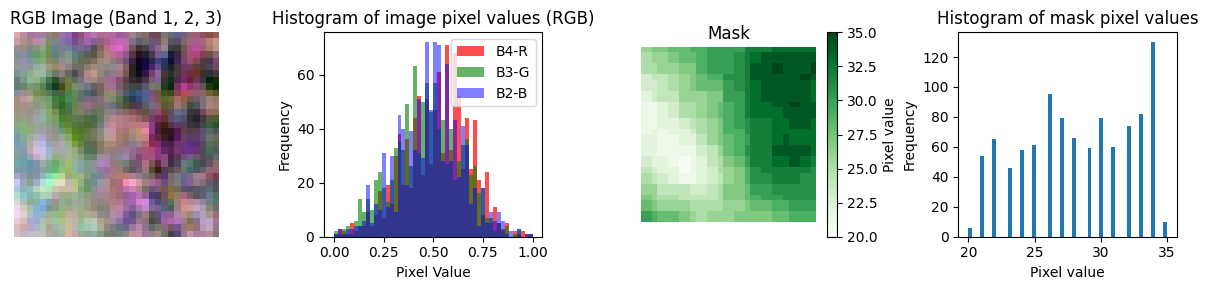

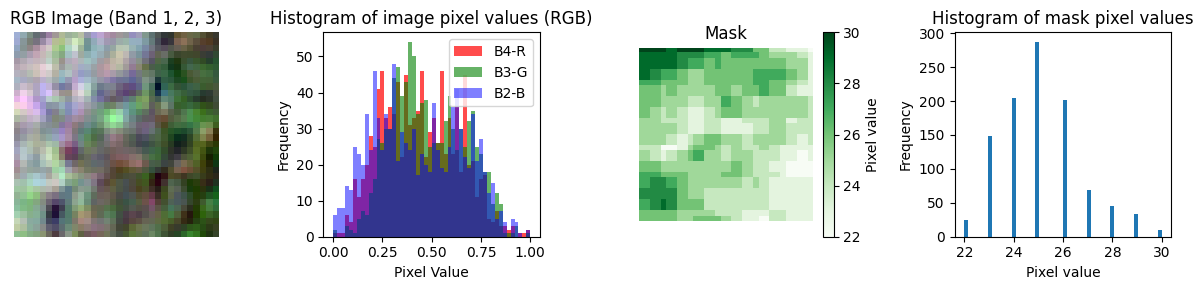

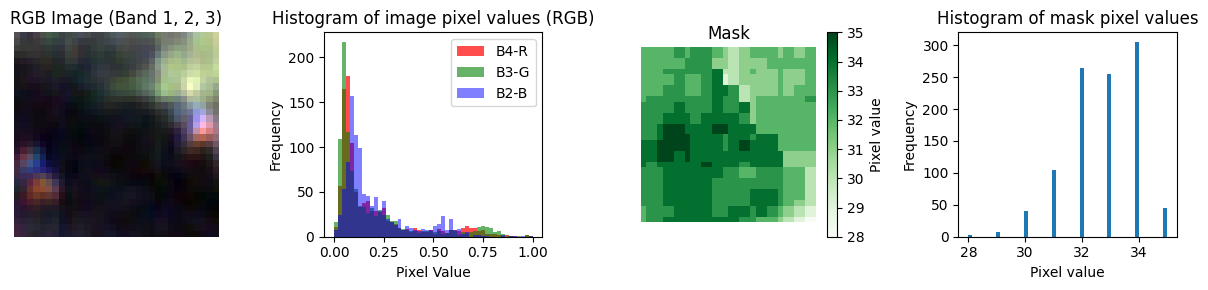

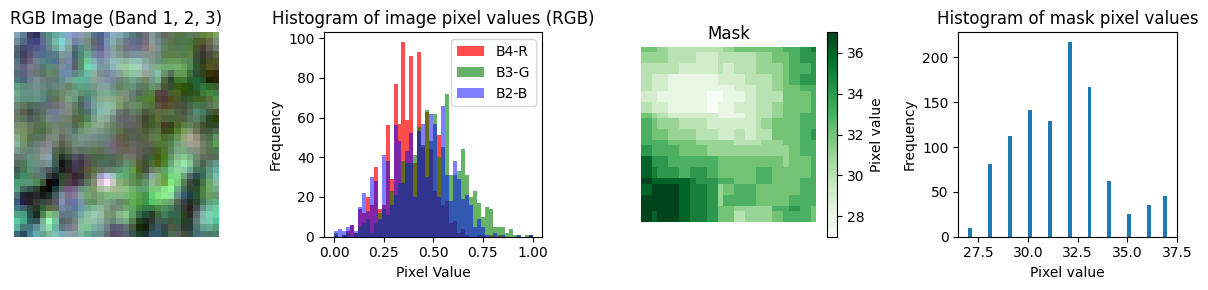

In [4]:
for i in range(0,images.shape[0]):
    image = images[i].numpy()
    mask = masks[i].numpy()
    show_image_histogram_mask(image, mask)

In [5]:
transforms_train = TransformCustom12(augmentations=[
  RandomHorizontalFlip(p=0.5),
  RandomVerticalFlip(p=0.5),
  RandomRotation(angles=(90,180,270), p=0.5)
])

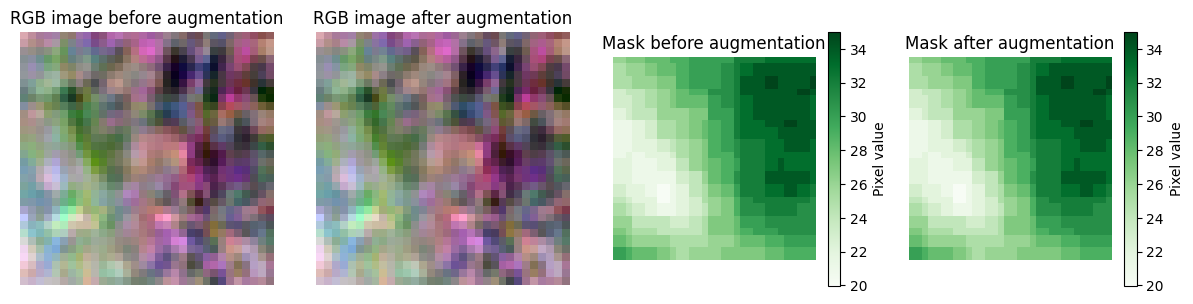

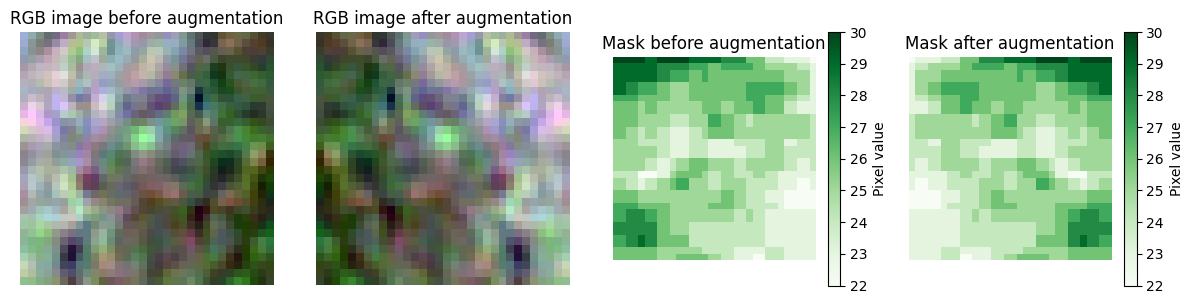

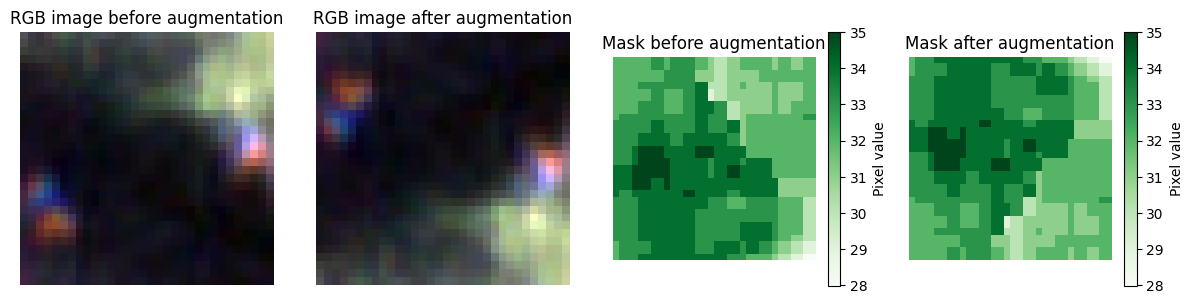

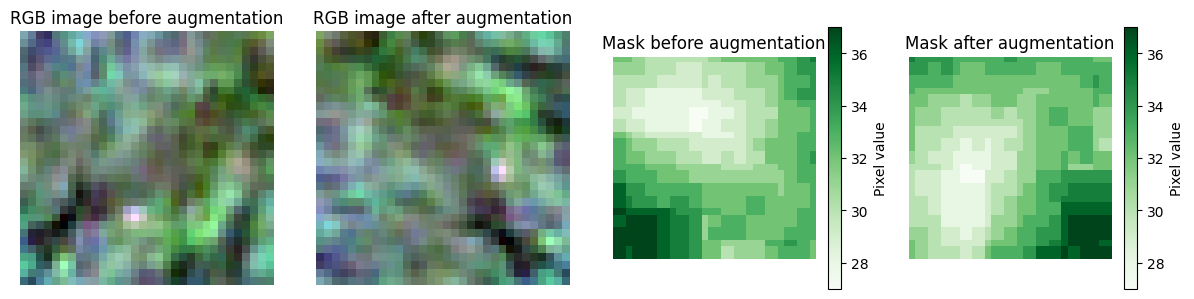

In [6]:
train_trandform_dl = Sentinel2(csv_path=csv_path, split="train",transform=transforms_train, RGB=False)
train_transform_loader = DataLoader(train_trandform_dl, batch_size=4, shuffle=False)

train_dl = Sentinel2(csv_path=csv_path, split="train",transform=None)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)
 
images_before, masks_before = next(iter(train_loader))
images_after, masks_after = next(iter(train_transform_loader))

for i in range(0,images_before.shape[0]):
    image_before = images_before[i].numpy()
    mask_before = masks_before[i].numpy()

    image_after = images_after[i].numpy()
    mask_after = masks_after[i].numpy()

    show_before_after_augmentation(image_before, image_after, mask_before, mask_after)

In [7]:
test_RGB_dl = Sentinel2(csv_path=csv_path, split="test", RGB=True)
test_RGB_loader = DataLoader(test_RGB_dl, batch_size=4, shuffle=False) 

test_12_dl = Sentinel2(csv_path=csv_path, split="test", RGB=False)
test_12_loader = DataLoader(test_12_dl, batch_size=4, shuffle=False) 

images_RGB, masks = next(iter(test_RGB_loader))
images_12, _ = next(iter(test_12_loader))

images_RGB = images_RGB.to('cuda')
images_12 = images_12.to('cuda')
masks = masks.to('cuda')


path_12_DA = 'Models/model_12bands_Aug_lr0.001_wd1e-05.pth'
path_12_nDA = 'Models/model_12bands_NotAug_lr0.001_wd1e-05.pth'
path_RGB_DA = 'Models/model_3bands_Aug_lr0.001_wd1e-05.pth'
path_RGB_nDA = 'Models/model_3bands_NotAug_lr0.001_wd1e-05.pth'

### ResNet101 ###
resnet101 = models.resnet101(pretrained = True)
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, 32 * 32),
    nn.Unflatten(1, (1, 32, 32)) 
)

### Model 12-DA ###
model12_DA = UNetRegressor(in_channels=images_12.shape[1], out_channels=1)
model12_DA.load_state_dict(torch.load(path_12_DA))

### Model 12-noDA ###
model12_nDA = UNetRegressor(in_channels=images_12.shape[1], out_channels=1)
model12_nDA.load_state_dict(torch.load(path_12_nDA))

### Model RGB-DA ###
modelRGB_DA = UNetRegressor(in_channels=images_RGB.shape[1], out_channels=1)
modelRGB_DA.load_state_dict(torch.load(path_RGB_DA))

### Model RGB-nDA ###
modelRGB_nDA = UNetRegressor(in_channels=images_RGB.shape[1], out_channels=1)
modelRGB_nDA.load_state_dict(torch.load(path_RGB_nDA))

resnet101 = resnet101.to('cuda')
model12_DA = model12_DA.to('cuda')
model12_nDA = model12_nDA.to('cuda')
modelRGB_DA = modelRGB_DA.to('cuda')
modelRGB_nDA = modelRGB_nDA.to('cuda')

resnet101.eval()
model12_DA.eval()
model12_nDA.eval()
modelRGB_DA.eval()
modelRGB_nDA.eval()

with torch.no_grad():
    outputs_resnet101 = resnet101(images_RGB)
    outputs_12_DA = model12_DA(images_12)
    outputs_12_nDA = model12_nDA(images_12)
    outputs_RGB_DA = modelRGB_DA(images_RGB)
    outputs_RGB_nDA = modelRGB_nDA(images_RGB)

outputs_resnet101 = outputs_resnet101.to('cpu').numpy()
outputs_12_DA = outputs_12_DA.to('cpu').numpy()
outputs_12_nDA = outputs_12_nDA.to('cpu').numpy()
outputs_RGB_DA = outputs_RGB_DA.to('cpu').numpy()
outputs_RGB_nDA = outputs_RGB_nDA.to('cpu').numpy()
masks = masks.to('cpu').numpy()


print(outputs_resnet101.shape)
print(outputs_12_DA.shape)
print(outputs_12_nDA.shape)
print(outputs_RGB_DA.shape)
print(outputs_RGB_nDA.shape)


(4, 1, 32, 32)
(4, 1, 32, 32)
(4, 1, 32, 32)
(4, 1, 32, 32)
(4, 1, 32, 32)


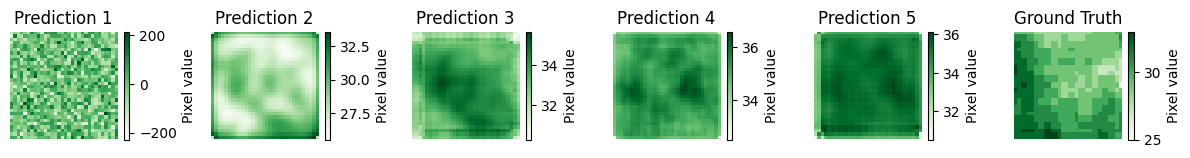

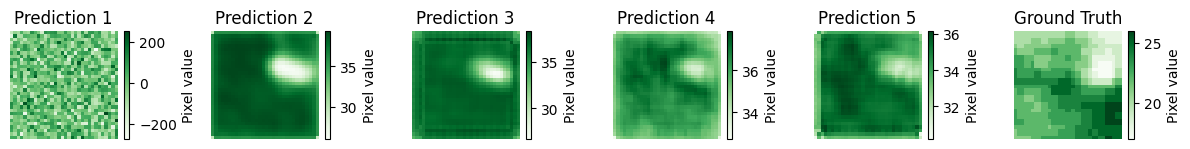

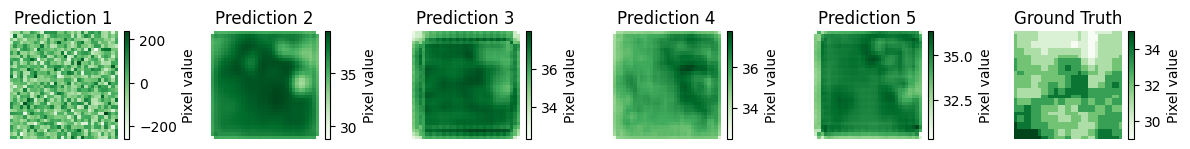

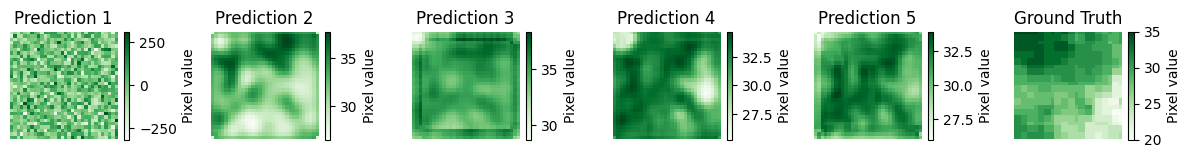

In [8]:
for i in range (0,outputs_resnet101.shape[0]):
    show_mask(outputs_resnet101[i], outputs_12_DA[i], outputs_12_nDA[i], outputs_RGB_DA[i], outputs_RGB_nDA[i], masks[i])